# 类比实验
- 32个受试者，按比例划分数据集，进行八折交叉验证
- 把测试受试者随机选择一个训练好的模型（不选择Wasserstein距离最近的模型）作为对比实验
- 与单受试者模型做对比，期望结果，准确率相差不多或比单受试者模型准确率略低
- 与所有受试者公用一个模型做对比，期望结果，比所有受试者公用模型准确率高很多

In [1]:
#加载飞桨、Numpy和相关类库
import numpy as np
import pyeeg as pe
import os
import random
import time

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import pyplot

from scipy.stats import wasserstein_distance

In [2]:
#加载一个受试者
def De_baseline(sub):
    dir='E:\JupyterNotebookWorkSpace\dataSet\\1280x258050(32x8064+2).npy'
    data=np.load(dir)
    subData = data[sub * 40 : (sub + 1) * 40]
    subData[: , -2:] = np.where(subData[: , -2:] >= 5 , 1 , -1)
    return subData

In [3]:
#数据集切60片，基线单独返回
def Data_set_partition(subData):
    features = subData[:,:-2]
    labels = subData[:,-2:]
    features = features.reshape(40,32,-1)
    baseline = features[:,:,:384]
    features = features[:,:,384:]
    
    dataList = []
    for i in range(40):
        for j in range(60):
            dataList.append(np.append(features[i][ : , j * 128 : (j + 1) * 128].reshape(-1) , labels[i]))

    dataList = np.array(dataList)

    return dataList, baseline

In [4]:
#特征提取
def feature_extraction(trainData, baseline):

    band = [4,8,13,16,30,45] #5 bands    band = [4,8,12,16,25,45]    
    window_size = 128 #Averaging band power of 1 sec
    step_size = 128 #Each 1 sec update once
    sample_rate = 128 #Sampling rate of 128 Hz

    features = trainData[:,:-2]
    labels = trainData[:,-2:]
    features = features.reshape(features.shape[0],32,128)

    newData=[]
    for i in range(features.shape[0]):    #样本数
        channel_features=[]
        for j in range(32):
            X = features[i][j]
            Y = pe.bin_power(X, band, sample_rate)
            channel_features += list(Y[0])
            ###################################################################################
        channel_features += list(labels[i])    #添加标签
        newData.append(channel_features)
    trainData = np.array(newData)

    #计算频域基线
    features = baseline

    newData=[]
    for i in range(features.shape[0]):    #电影数
        channel_features=[]
        for k in range(3):
            baseline_feature = []
            for j in range(32):
                X = features[i][j][k * 128 : (k + 1) * 128]
                Y = pe.bin_power(X, band, sample_rate)
                baseline_feature += list(Y[0])
            channel_features.append(baseline_feature)    #求基线的均值还是均值的基线？
        newData.append(np.array(channel_features).mean(axis = 0))
    newData = np.array(newData)
    
# 减去基线特征
    for i in range(40):
        trainData[i * 60 : (i + 1) * 60 , : 160] -= newData[i]

    return trainData

In [5]:
# AllSubFreq = []    #保存所有受试者的频域特征32*2400*160(不含标签)
# for sub in range(32):
#     SubData = De_baseline(sub)
#     dataList, baseline = Data_set_partition(SubData)
#     trainData = feature_extraction(dataList, baseline)
#     AllSubFreq.append(trainData)
# AllSubFreq = np.array(AllSubFreq)
# print(AllSubFreq.shape)
# AllSubFreq = np.reshape(AllSubFreq, (-1, 162))
# print(AllSubFreq.shape)
# np.save("./with_label_DE_baseline_AllSubFreq.npy",AllSubFreq)

In [6]:
# #计算KL散度
# import numpy as np
# import scipy.stats

# # 利用scipy API进行计算
# # scipy计算函数可以处理非归一化情况，因此这里使用
# # scipy.stats.entropy(x, y)或scipy.stats.entropy(px, py)均可
# KL = np.zeros((32,32))
# for i in range(32):
#     for j in range(32):
#         x = AllSubFreq[i]
#         y = AllSubFreq[j]
#         KL[i][j] = scipy.stats.entropy(x, y)
# print(KL)
# np.save("work/data/KL_AllSubFreq.npy",KL)

In [7]:
# #计算JS散度

# import numpy as np
# import scipy.stats

# def JS_divergence(p,q):
#     M=(p+q)/2
#     return 0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)

# JS = np.zeros((32,32))
# for i in range(32):
#     for j in range(32):
#         x = AllSubFreq[i]
#         y = AllSubFreq[j]
#         JS[i][j] = JS_divergence(x, y)
# np.set_printoptions(threshold = 1e6)
# print(JS)
# np.save("work/data/JS_AllSubFreq.npy",JS)


In [8]:
# def Gaussian_normalization(trainData, testData):
#     """高斯归一化"""

#     #训练样本归一化
#     feature=trainData[:,:-2]
#     mean=feature.mean(axis=0)
#     std=feature.std(axis=0)
#     feature-=mean
#     feature/=std
#     trainData[:,:-2] = feature

#     #测试样本归一化
#     feature=testData[:,:-2]
#     feature-=mean
#     feature/=std
#     testData[:,:-2] = feature

#     return trainData, testData

In [9]:
#使用Wasserstein距离进行K-means聚类
from scipy.stats import wasserstein_distance

class K_Means(object):
    # k是分组数；tolerance‘中心点误差’；max_iter是迭代次数
    def __init__(self, k=2, tolerance=0.0000001, max_iter=30000):    #tolerance=0.0001,  max_iter=300
        self.k_ = k
        self.tolerance_ = tolerance
        self.max_iter_ = max_iter

    def fit(self, data):
        self.centers_ = {}
        for i in range(self.k_):
            self.centers_[i] = data[i]

        for i in range(self.max_iter_):
            self.clf_ = {}
            for j in range(self.k_):
                self.clf_[j] = []
            # print("质点:",self.centers_)
            for SubIndexId, feature in enumerate(data):
                # distances = [np.linalg.norm(feature-self.centers[center]) for center in self.centers]
                distances = []
                for center in self.centers_:
                    # 欧拉距离
                    # np.sqrt(np.sum((features-self.centers_[center])**2))
                    distances.append(wasserstein_distance(feature, self.centers_[center]))#np.linalg.norm(feature - self.centers_[center])
                classification = distances.index(min(distances))
                self.clf_[classification].append(SubIndexId)

            # print("分组情况:",self.clf_)
            prev_centers = dict(self.centers_)
            
            self.flag = True    #聚类是否成功
            for c in self.clf_:
                if(len(self.clf_[c]) == 0):
                    self.flag = False
                    print('\n第{}次迭代：'.format(i))
                    print('************************聚类中心无样本截止！******************************')
                    return
                self.centers_[c] = np.average(data[np.array(self.clf_[c])], axis=0)

            # '中心点'是否在误差范围
            optimized = True
            for center in self.centers_:
                org_centers = prev_centers[center]
                cur_centers = self.centers_[center]
                if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:
                    optimized = False
            if optimized:
                print('迭代次数：', i)
                break

    def predict(self, p_data):
        allIndex = []
        for oneTestSample in p_data:
            distances = [wasserstein_distance(oneTestSample, self.centers_[center]) for center in self.centers_]#np.linalg.norm(p_data - self.centers_[center])
            index = distances.index(min(distances))
            allIndex.append(index)
        return np.array(allIndex)

In [10]:
def W_K_means(n_cluster, trainSet):
    AllSubFreq = trainSet
    #print(AllSubFreq.shape)

    k_means = K_Means(k=n_cluster)
    k_means.fit(data  = AllSubFreq)
    return k_means
    # print(k_means.centers_)
    # for center in k_means.centers_:
    #     pyplot.scatter(k_means.centers_[center][0], k_means.centers_[center][1], marker='*', s=150)

    # for cat in k_means.clf_:
    #     for point in k_means.clf_[cat]:
    #         pyplot.scatter(point[0], point[1], c=('r' if cat == 0 else 'b'))

    # predict = [[2, 1],[6, 9]]
    # for feature in predict:
    #     cat = k_means.predict(feature)
    #     pyplot.scatter(feature[0], feature[1], c=('r' if cat == 0 else 'b'), marker='x')

    # pyplot.show()

In [11]:
from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def trainModel(trainData, testData, Edim, modelId):
    dim = Edim
    
    trainLabel = trainData[:, -2:]
    trainData = trainData[:, :-2]
    trainLabel = trainLabel[:, dim]
    
    testLabel = testData[:, -2:]
    testData = testData[:, :-2]
    testLabel = testLabel[:, dim]
    print('model {}\ttrainNum:{}\ttestNum:{}\t训练：测试 = {:.2f}'.format(modelId, trainData.shape[0], testData.shape[0], trainData.shape[0] / testData.shape[0]), end = '\t')
    
#     svmModel = svm.SVC()
#     svmModel.fit(data_training, valtrain) 
#     ypredict=svmModel.predict(data_testing)
#     print("SVMacc：",accuracy_score(ypredict,valtest)) 

    rfModel = RandomForestClassifier(n_estimators=512, n_jobs=16)
    rfModel.fit(trainData, trainLabel)
    ypredict = rfModel.predict(testData)
    acc = accuracy_score(ypredict,testLabel)
    print("acc = {:.2f}".format(acc))
    return acc, testData.shape[0]

数据集shape： (76800, 162)
-------------------------------------------第1折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	acc = 0.51
K=2：	迭代次数： 11
model 0	trainNum:63512	testNum:8777	训练：测试 = 7.24	acc = 0.53
model 1	trainNum:3688	testNum:823	训练：测试 = 4.48	acc = 0.45
K=3：	迭代次数： 36
model 0	trainNum:2965	testNum:621	训练：测试 = 4.77	acc = 0.53
model 1	trainNum:3509	testNum:733	训练：测试 = 4.79	acc = 0.44
model 2	trainNum:60726	testNum:8246	训练：测试 = 7.36	acc = 0.52
K=4：	迭代次数： 50
model 0	trainNum:45992	testNum:5135	训练：测试 = 8.96	acc = 0.52
model 1	trainNum:3040	testNum:525	训练：测试 = 5.79	acc = 0.40
model 2	trainNum:16190	testNum:3510	训练：测试 = 4.61	acc = 0.50
model 3	trainNum:1978	testNum:430	训练：测试 = 4.60	acc = 0.55
K=5：	迭代次数： 86
model 0	trainNum:43229	testNum:5501	训练：测试 = 7.86	acc = 0.52
model 1	trainNum:2841	testNum:422	训练：测试 = 6.73	acc = 0.39
model 2	trainNum:6739	testNum:2176	训练：测

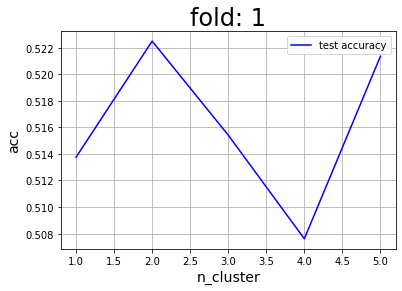

-------------------------------------------第2折交叉验证开始-------------------------------------------------
trainSet.shape = (67200, 162), testSet.shape = (9600, 162)
K=1：	迭代次数： 0
model 0	trainNum:67200	testNum:9600	训练：测试 = 7.00	acc = 0.63
K=2：	迭代次数： 18
model0无测试样本
model 1	trainNum:62434	testNum:9600	训练：测试 = 6.50	acc = 0.63
K=3：	

In [ ]:
# 开始对训练集聚类
valence_or_arousal = -2    #-2 : valence;-1 : arousal

allSub = np.load("./with_label_DE_baseline_AllSubFreq.npy")
print('数据集shape：', allSub.shape)

subIndex = np.array([i for i in range(32 * 2400)])
# 8折交叉验证
allAcc = []
for fold in range(1, 9):
    print('-------------------------------------------第{}折交叉验证开始-------------------------------------------------'.format(fold))
    # 数据集划分
    testIndex = subIndex[(fold - 1) * 4 * 2400 : fold * 4 * 2400]
    trainIndex = subIndex[np.array(list(set(subIndex) - set(subIndex[(fold - 1) * 4 * 2400 : fold * 4 * 2400])))]

    trainSet = allSub[trainIndex]
    testSet = allSub[testIndex]
    print('trainSet.shape = {}, testSet.shape = {}'.format(trainSet.shape, testSet.shape))

    trainFeature = trainSet[:, :-2]
    testFeature = testSet[:, :-2]
    
    ####################################################
    # 整体归一化（还可以在每个模型内部做归一化）
    featureMean = trainFeature.mean(axis = 0)
    featureStd = trainFeature.std(axis = 0)
    
    trainFeature -= featureMean
    trainFeature /= featureStd
    testFeature -= featureMean
    testFeature /= featureStd
    ####################################################

    foldAcc = []
    for num_cluster in range(1, 33):
        print('K={}：'.format(num_cluster),end = '\t')
        #    *** 在这里我们关心哪些人的哪些视频被聚在了一起 ***    #
        k_means_machine = W_K_means(num_cluster, trainFeature)
        if(k_means_machine.flag == False):
            continue
        # 使用建立的K-means模型对测试集分类
        allIndex = k_means_machine.predict(testFeature)
        
        classList = k_means_machine.clf_
        
        ###################################################
        #统计样本在每个模型的分布
        
        trainSampleScatter = np.zeros((num_cluster, 1120))
        testSampleScatter = np.zeros((num_cluster, 160))
        for j in range(len(classList)):
            for idxS, scatter in enumerate(allIndex) :
                testSampleScatter[j][idxS//60] += scatter == j
            
            for scatter in classList[j] :
                trainSampleScatter[j][scatter//60] += 1
        np.save('E:/JupyterNotebookWorkSpace/刘敦辉/多受试者通用模型/分人_1秒样本聚类RF/样本在每个模型的分布/fold{}K{}trainSample.npy'.format(fold, num_cluster), trainSampleScatter)
        np.save('E:/JupyterNotebookWorkSpace/刘敦辉/多受试者通用模型/分人_1秒样本聚类RF/样本在每个模型的分布/fold{}K{}testSample.npy'.format(fold, num_cluster), testSampleScatter)
        ###################################################
        
        clusterMean = []
        K_ModelAcc = []
        for j in range(len(classList)):
            testData = testSet[allIndex == j]
            if(testData.shape[0]==0):
                print('model{}无测试样本'.format(j))
                continue
            acc, testNum = trainModel(trainSet[np.array(classList[j])], testData, valence_or_arousal, modelId = j)
            K_ModelAcc.append(acc)
            # 求加权准确率
            clusterMean.append(acc * testNum)
        clusterMean = np.array(clusterMean).sum() / testSet.shape[0]
        foldAcc.append(clusterMean)
        allAcc.append(K_ModelAcc)
        
    plt.title("fold: {}".format(fold), fontsize=24)
    plt.xlabel("n_cluster", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    n_cluster = [i for i in range(1, len(foldAcc) + 1)]
    plt.plot(n_cluster, foldAcc, color='blue', label='test accuracy')

    plt.grid()
    plt.legend()
    plt.show()
np.save('所有准确率_8折x32种聚类_聚类容忍度调小1000倍.npy', np.array(allAcc))

In [ ]:
ls = np.zeros((1,3))
ls[0] += np.array([1,2,3], dtype = 'int64') == 1
print(ls)

In [ ]:
#    *** 在这里我们关心哪些人的哪些视频被聚在了一起 ***    #
# 除零警告
# 为什么聚一类，一次都没迭代就收敛了，至少迭代一次吧，tolerance，是不是容忍度太高了
# 聚类中心初始化问题，可能会在迭代过程中出现某个聚类中心中没有样本的情况